# Workflow Observability

## Use native instrumentation from LlamaIndex + OpenTelemetry to fine-grain tracing in your code!

In this notebook, we will go through an example of how to use instrumentation natively implemented in `llama-index` (combined with OpenTelemetry) to define costum span and events within your code.



## 1. Setting up

Before diving deep into all of this, let's install all the needed dependencies.

In [19]:
! pip install -q llama-index-workflows llama-index-instrumentation llama-index-llms-openai llama-index-observability-otel llama-cloud-services llama-index-indices-managed-llama-cloud llama-cloud llama-index-embeddings-openai

## 2. Experiment with instrumentation

Let's now play around with `llama-index` dispatcher and see how we can make it work.

Let's start by initializing it:

In [47]:
from llama_index_instrumentation import get_dispatcher

dispatcher = get_dispatcher()

Now we can use the `@dispatcher.span` decorator on a function that we defined to emit spans (containers for events) and use `dispatcher.event` to emit and event (we can define custom events by subclassing the `BaseEvent` class):

In [48]:
from llama_index_instrumentation.base import BaseEvent


class ExampleEvent(BaseEvent):
    data: str


@dispatcher.span
def example_fn(data: str) -> None:
    dispatcher.event(ExampleEvent(data=data))
    s = "This are example string data: " + data
    print(s)

## 3. Add OpenTelemetry

We can now add OpenTelemetry so that we can export all our span and events as ordered traces.
We will be using the LlamaIndex integration for that, `llama-index-observability-otel`.


We start by defining a custom `SpanExporter` that can write all our traces to a file:

In [9]:
import os
from pathlib import Path

from llama_index.observability.otel import LlamaIndexOpenTelemetry
from opentelemetry.sdk.trace.export import SpanExporter, SpanExportResult
from opentelemetry.sdk.trace import ReadableSpan
from typing import Optional, Callable, Sequence
from os import linesep


class FileSpanExporter(SpanExporter):
    """Implementation of :class:`SpanExporter` that prints spans to the
    console.

    This class can be used for diagnostic purposes. It prints the exported
    spans to the console STDOUT.
    """

    def __init__(
        self,
        service_name: str | None = None,
        file_path: Optional[os.PathLike[str]] = None,
        formatter: Callable[[ReadableSpan], str] = lambda span: span.to_json()
        + linesep,
    ):
        if not file_path:
            file_path = "traces.json"
        if Path(file_path).exists():
            raise ValueError(f"File {file_path} already exists")
        self.file_path = file_path
        self.formatter = formatter
        self.service_name = service_name

    def export(self, spans: Sequence[ReadableSpan]) -> SpanExportResult:
        print(f"Writing {len(spans)} spans to {self.file_path}")
        if Path(self.file_path).exists():
            mode = "a"
        else:
            mode = "w"
        with open(self.file_path, mode) as out:
            for span in spans:
                out.write(self.formatter(span))
            out.flush()
        return SpanExportResult.SUCCESS

    def force_flush(self, timeout_millis: int = 30000) -> bool:
        return True

Now we can pass that to the instrumentation class as a span exporter

In [7]:
se = FileSpanExporter(file_path="traces_example.json")

instrumentor = LlamaIndexOpenTelemetry(
    span_exporter=se,
    service_name_or_resource="example_service",
)

And we can try and see how events are registered just by calling an LLM, for example:

In [10]:
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass()

··········


In [9]:
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-4.1")

In [10]:
instrumentor.start_registering()

res = llm.complete("Hello there, who are you?")
print(res)

Hello! I’m ChatGPT, an AI language model created by OpenAI. I’m here to help answer your questions, provide information, or just have a conversation. How can I assist you today?


In [11]:
import json

with open("traces_example.json") as f:
    print(f.read())

{
    "name": "OpenAI.complete-59d8a4f6-d02c-479f-a65c-242123c60c14",
    "context": {
        "trace_id": "0xbce7387b04845abee7e607acba7c2983",
        "span_id": "0xab09d93f26c50562",
        "trace_state": "[]"
    },
    "kind": "SpanKind.INTERNAL",
    "parent_id": null,
    "start_time": "2025-07-03T08:09:03.170616Z",
    "end_time": "2025-07-03T08:09:04.945024Z",
    "status": {
        "status_code": "OK"
    },
    "attributes": {},
    "events": [
        {
            "name": "LLMCompletionStartEvent",
            "timestamp": "2025-07-03T08:09:04.944978Z",
            "attributes": {
                "id_": "10610766-1070-4eb4-a333-464cd3ab4c51",
                "span_id": "OpenAI.complete-59d8a4f6-d02c-479f-a65c-242123c60c14",
                "prompt": "Hello there, who are you?",
                "class_name": "LLMCompletionStartEvent"
            }
        },
        {
            "name": "LLMCompletionEndEvent",
            "timestamp": "2025-07-03T08:09:04.945002Z",
    

## 4. Instrument a workflow

Now that we know:
1. How to dispatch span and events
2. How to register those events as OpenTelemetry traces

It's time to use this knowledge to build and instrument a workflow!

The workflow that we want to build automates customer support e-mails by extracting important information from them, gather answers to the customers' questions from a company database, ask for feedback from a human employee and, if the feedback is positive, send the email.

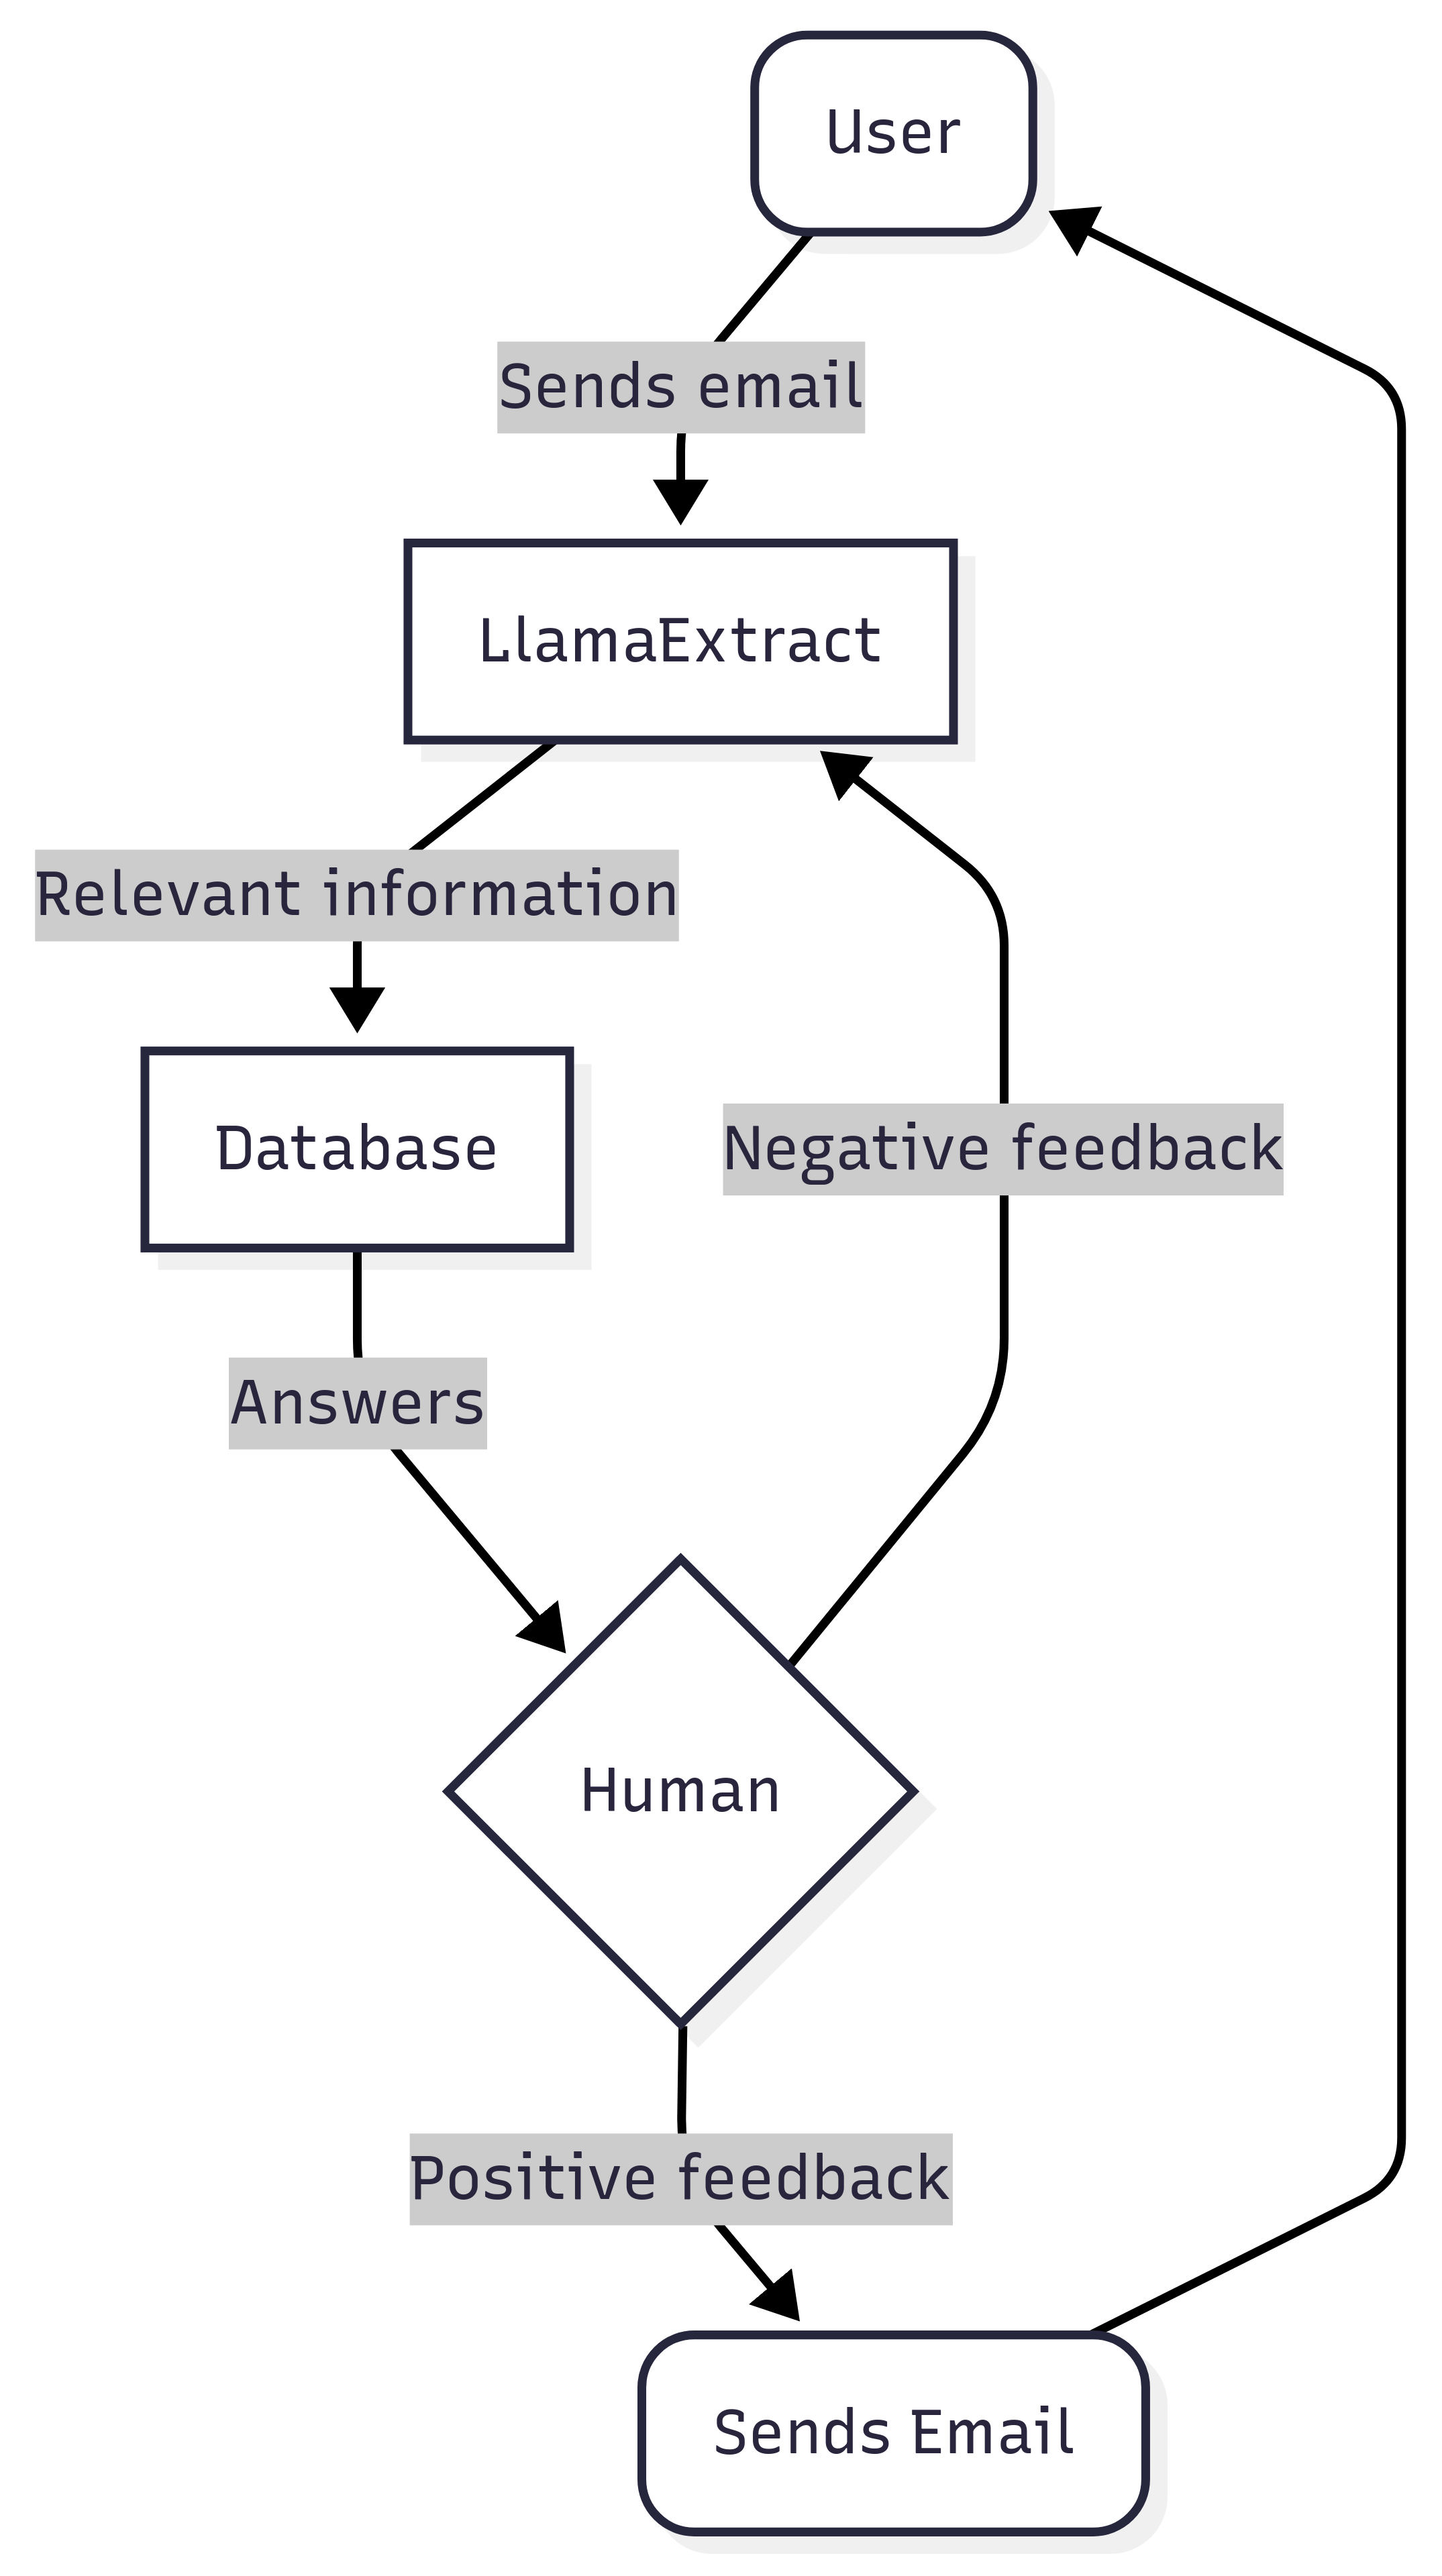

### 4.1 Define custom events

The first thing that we need to do is to define the custom event that we will us throughout our framework.

We can do it by subclassing the general `Event` classes that the `llama-index-workflows` package provides us with

In [28]:
from workflows.events import (
    HumanResponseEvent,
    Event,
    StartEvent,
    StopEvent,
    InputRequiredEvent,
)
from typing import Literal, List, Dict


class EmailEvent(StartEvent):
    """Triggers the workflow when an e-mail is received."""

    email_content: str


class InformationExtractionEvent(Event):
    """Event that contains the extracted information from the email."""

    sender_details: str
    support_category: Literal["technical", "sales", "general_information"]
    support_questions: List[str]
    extra_information: str


class QuestionEvent(Event):
    """Event containing one or more questions to retrieve information from the company database."""

    questions: List[str]


class RetrievalEvent(Event):
    """Event that contains the retrieved information"""

    information: Dict[str, str]


class CandidateEmailEvent(InputRequiredEvent):
    """Event where we generate a candidate email to send back to the user in response to their support questions"""

    candidate_email: str


class HumanFeedbackEvent(HumanResponseEvent):
    """Ask for human feedback."""

    approved: bool
    feedback: str


class SendEmailEvent(StopEvent):
    """Event where the agent sends an email"""

    email_content: str
    email_successfully_sent: bool


class ProgressEvent(Event):
    msg: str

### 4.2 Define custom resources

[Resources](https://docs.llamaindex.ai/en/stable/understanding/workflows/resources/) are a way of performing dependency injection in workflow steps.

We will need three main resources:

1. An extraction agent to perform information extraction from the email
2. An LLM to provide us with questions to ask to the company database to retrieve information
3. The company database client to perform information retrieval

Let's first build our extraction agent:


In [11]:
os.environ["LLAMACLOUD_API_KEY"] = getpass()

··········


We need to specify a schema for the extraction first:

In [14]:
from pydantic import BaseModel, Field


class SenderDetails(BaseModel):
    name: str = Field(description="Name of the sender seeking support")
    email_address: str = Field(description="Email address of the sender")
    company: Optional[str] = Field(
        descrption="Company for which the sender works", default=None
    )
    role: Optional[str] = Field(descrption="Job role of the sender", default=None)


class SupportEmailInformation(BaseModel):
    sender_details: SenderDetails
    support_category: Literal["technical", "sales", "general_information"]
    support_questions: List[str]
    extra_information: str

Then we create the extraction agent using `llama-cloud-services`, specifically [LlamaExtract](https://www.llamaindex.ai/llamaextract), our best-in-class platform for document extraction:

In [16]:
from llama_cloud_services import LlamaExtract

client = LlamaExtract(api_key=os.getenv("LLAMACLOUD_API_KEY"))
agent = client.create_agent(
    name="EmailSupportAgent", data_schema=SupportEmailInformation
)
os.environ["EXTRACT_AGENT_ID"] = agent.id

Now that we created the agent, let's create a company database that we can query. We will do it using [LlamaCloud Index](https://docs.llamaindex.ai/en/stable/module_guides/indexing/llama_cloud_index/), a fully automated ingestion pipeline for our company documents.

Let's imagine that we are a company called YourBestSoftware, and we sell productivity tools for enterprise solutions.

Let's get the documents related to techinical, sales and general support for our company:

In [18]:
! mkdir data
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/support/yourbestsoftware_technical.pdf > data/yourbestsoftware_technical.pdf
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/support/yourbestsoftware_sales.pdf > data/yourbestsoftware_sales.pdf
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/support/yourbestsoftware_general.pdf > data/yourbestsoftware_general.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2564k  100 2564k    0     0  6824k      0 --:--:-- --:--:-- --:--:-- 6838k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4108k  100 4108k    0     0  6065k      0 --:--:-- --:--:-- --:--:-- 6059k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4526k  100 4526k    0     0  6711k      0 --:--:-- --:--:-- --:--:-- 6715k


Now let's upload them to a LlamaCloud Index:

In [20]:
from llama_cloud import (
    PipelineCreateEmbeddingConfig_OpenaiEmbedding,
    PipelineTransformConfig_Advanced,
    AdvancedModeTransformConfigChunkingConfig_Sentence,
    AdvancedModeTransformConfigSegmentationConfig_Page,
    PipelineCreate,
)
from llama_cloud.client import LlamaCloud
from llama_index.embeddings.openai import OpenAIEmbedding

embed_model = OpenAIEmbedding(
    model="text-embedding-3-small", api_key=os.getenv("OPENAI_API_KEY")
)

client = LlamaCloud(token=os.getenv("LLAMACLOUD_API_KEY"))

embedding_config = PipelineCreateEmbeddingConfig_OpenaiEmbedding(
    type="OPENAI_EMBEDDING",
    component=embed_model,
)

segm_config = AdvancedModeTransformConfigSegmentationConfig_Page(mode="page")
chunk_config = AdvancedModeTransformConfigChunkingConfig_Sentence(
    chunk_size=1024,
    chunk_overlap=200,
    separator="<whitespace>",
    paragraph_separator="\n\n",
    mode="sentence",
)

transform_config = PipelineTransformConfig_Advanced(
    segmentation_config=segm_config,
    chunking_config=chunk_config,
    mode="advanced",
)

pipeline_request = PipelineCreate(
    name="yourbestsoftware_pipeline",
    embedding_config=embedding_config,
    transform_config=transform_config,
)

pipeline = client.pipelines.upsert_pipeline(request=pipeline_request)

os.environ["PIPELINE_ID"] = pipeline.id

Now let's upload our files to this pipeline we just created:

In [24]:
files: List[dict] = []
fls = [os.path.join("data", f) for f in os.listdir("data/")]

for fl in fls:
    with open(fl, "rb") as f:
        file = client.files.upload_file(upload_file=f)
    files.append({"file_id": file.id})

client.pipelines.add_files_to_pipeline_api(
    pipeline_id=os.getenv("PIPELINE_ID"), request=files
)

[PipelineFile(id='3bc87fef-fa6b-4e30-a03e-e8ab590997ec', created_at=datetime.datetime(2025, 7, 3, 10, 20, 48, 468458, tzinfo=datetime.timezone.utc), updated_at=datetime.datetime(2025, 7, 3, 10, 20, 48, 468458, tzinfo=datetime.timezone.utc), name='yourbestsoftware_technical.pdf', external_file_id='yourbestsoftware_technical.pdf', file_size=2626006, file_type='pdf', project_id='cc9a8767-9f59-42f9-be81-4ece7e3b3031', last_modified_at=datetime.datetime(2025, 7, 3, 10, 20, 46, tzinfo=datetime.timezone.utc), resource_info=None, permission_info=None, data_source_id=None, file_id='83fe1572-43fa-4797-90ba-e0975c37a7a4', pipeline_id='eb673259-8e93-42f7-89c9-2e56671052bb', custom_metadata=None, config_hash=None, indexed_page_count=0, status=<PipelineFileStatus.NOT_STARTED: 'NOT_STARTED'>, status_updated_at=datetime.datetime(2025, 7, 3, 10, 20, 52, 988930)),
 PipelineFile(id='a262ce4b-cc9e-4260-bbb3-1a76284da5d2', created_at=datetime.datetime(2025, 7, 3, 10, 20, 48, 468458, tzinfo=datetime.timezon

It will take some minutes for our pipeline to load and process all the files, so in the meantime we define the functions that would work as resources:

In [29]:
from llama_index.indices.managed.llama_cloud import LlamaCloudIndex
from llama_index.llms.openai import OpenAIResponses
from llama_index.core.query_engine import BaseQueryEngine
from llama_cloud_services.extract.extract import ExtractionAgent
from llama_index.core.llms.structured_llm import StructuredLLM
from llama_index.core.llms import LLM
from pydantic import BaseModel, Field

llm = OpenAIResponses(model="gpt-4.1")


class SupportQuestions(BaseModel):
    questions: List[str] = Field(
        description="Support questions to ask within the company database to retrieve the most information about the users' requests"
    )


# we define a structured LLM that would give us the support questions to ask to the company database
llm_struct = llm.as_structured_llm(SupportQuestions)

query_engine = LlamaCloudIndex(
    api_key=os.getenv("LLAMACLOUD_API_KEY"), pipeline_id=os.getenv("PIPELINE_ID")
).as_query_engine(llm=llm)


async def get_extract_agent(*args, **kwargs) -> ExtractionAgent:
    return agent


async def get_company_database(*args, **kwargs) -> BaseQueryEngine:
    return query_engine


async def get_llm(*args, **kwargs) -> StructuredLLM:
    return llm_struct


async def get_llm_for_email(*args, **kwargs) -> LLM:
    return llm

### 4.3 Create the workflow

Finally, after defining events and resources, we can create our workflow:

In [32]:
class WorkflowState(BaseModel):
    email_text: str = ""
    candidate_email: str = ""

In [41]:
import uuid

from llama_index.core.llms import ChatMessage
from workflows import Workflow, Context, step
from workflows.resource import Resource
from llama_cloud_services.extract import SourceText
from typing import Annotated, Union


class EmailSupportWorkflow(Workflow):
    # remember to use the step decorator!
    @step
    async def extract_email_information(
        self,
        event: EmailEvent,
        ctx: Context[WorkflowState],
        extraction_agent: Annotated[ExtractionAgent, Resource(get_extract_agent)],
    ) -> Union[InformationExtractionEvent, SendEmailEvent]:
        extracted_content = await extraction_agent.aextract(
            files=SourceText(
                text_content=text, filename=f"support_email_{str(uuid.uuid4())}.txt"
            )
        )
        if extracted_content:
            extracted_data = SupportEmailInformation.model_validate(
                extracted_content.data
            )
            ctx.write_event_to_stream(
                ProgressEvent(msg="Information extracted successfully")
            )
            return InformationExtractionEvent(
                sender_details=extracted_data.sender_details.model_dump_json(),
                support_category=extracted_data.support_category,
                support_questions=extracted_data.support_questions,
                extra_information=extracted_data.extra_information,
            )
        ctx.write_event_to_stream(ProgressEvent(msg="Information extraction failed"))
        state = await ctx.store.get_state()
        state.email_text = event.email_content
        await ctx.store.set_state(state)
        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to extract information, please re-run the workflow",
        )

    @step
    async def generate_questions_to_ask(
        self,
        event: InformationExtractionEvent,
        ctx: Context[WorkflowState],
        llm: Annotated[StructuredLLM, Resource(get_llm)],
    ) -> Union[QuestionEvent, SendEmailEvent]:
        response = await llm.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of a support email:\n\n```json\n{event.model_dump_json()}\n```\n\nCan you please generate one or more support questions to ask to the company database to solve the users' problem?",
                )
            ]
        )
        if response.message.content:
            response_json = json.loads(response.message.content)
            ctx.write_event_to_stream(
                ProgressEvent(msg="Questions generated successfully")
            )
            return QuestionEvent(questions=response_json["questions"])
        ctx.write_event_to_stream(ProgressEvent(msg="Questions generation failed"))
        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to generate questions, please re-run the workflow",
        )

    @step
    async def information_retrieval(
        self,
        event: QuestionEvent,
        ctx: Context[WorkflowState],
        company_database: Annotated[BaseQueryEngine, Resource(get_company_database)],
    ) -> RetrievalEvent:
        q_and_a: Dict[str, str] = {}
        for question in event.questions:
            response = await company_database.aquery(question)
            q_and_a.update({question: response.response or ""})
        ctx.write_event_to_stream(
            ProgressEvent(msg="Answers to questions generated successfully")
        )
        return RetrievalEvent(information=q_and_a)

    @step
    async def create_email_event(
        self,
        event: RetrievalEvent,
        ctx: Context[WorkflowState],
        llm_email: Annotated[LLM, Resource(get_llm_for_email)],
    ) -> CandidateEmailEvent:
        response = await llm_email.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of question-answer pairs for the support answers of a user:\n\n```json\n{json.dumps(event.information, indent=4)}\n```\n\nCan you please generate the text of the email to send back to the customer and answer their questions? Generate only the email.",
                )
            ]
        )
        ctx.write_event_to_stream(ProgressEvent(msg="Generated candidate email"))
        state = await ctx.store.get_state()
        state.candidate_email = response.message.content
        await ctx.store.set_state(state)
        return CandidateEmailEvent(candidate_email=response.message.content)

    @step
    async def send_email_or_restart(
        self, event: HumanFeedbackEvent, ctx: Context[WorkflowState]
    ) -> Union[SendEmailEvent, EmailEvent]:
        if event.approved:
            state = await ctx.store.get_state()
            return SendEmailEvent(
                email_content=state.candidate_email,
                email_successfully_sent=True,
                result="Email successfully sent",
            )
        else:
            state = await ctx.store.get_state()
            return EmailEvent(
                email_content=state.email_text,
            )

Now we will run the workflow as-is, an you will already see that it produces OpenTelemtry traces.

In [37]:
# first let's get some data
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/emails/general.txt > general.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1086  100  1086    0     0   5869      0 --:--:-- --:--:-- --:--:--  5902


In [38]:
# Let's read these data

with open("general.txt", "r") as f:
    text = f.read()
text

"From: j.marino84@gmail.com  \nTo: support@yourbestsoftware.com  \nSubject: Request for General Assistance with Your Best Software Account and Features\n\nDear Support Team,\n\nI’m a fairly new user of Your Best Software and I was hoping to get some help understanding a few things related to my account and general use of the platform.\n\nI’m not encountering a specific error, but I’ve run into some confusion around how certain features are meant to work. In particular, I’d appreciate some guidance on:\n\n- Navigating between different areas of the dashboard (some settings and tools seem to be nested in ways I can’t always find easily)\n- Understanding which features are included in my current subscription level\n- General best practices for setting up my workspace to get the most out of the platform\n\nAny documentation, tips, or pointers to the right support resources would be very helpful. If there's someone I can speak with directly or a walkthrough available, that would be even bet

In [39]:
# let's export the spans to a different files, and then start the instrumentation
se_1 = FileSpanExporter(file_path="workflow_1.json")

instrumentor_1 = LlamaIndexOpenTelemetry(
    span_exporter=se_1,
    service_name_or_resource="tracing.a.workflow.1",
)

instrumentor_1.start_registering()

In [43]:
wf = EmailSupportWorkflow(timeout=800)

handler = wf.run(start_event=EmailEvent(email_content=text))
async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg, flush=True)
    elif isinstance(ev, CandidateEmailEvent):
        print(f"Candidate email: {ev.candidate_email}", flush=True)
        approved = input("Approve? (y/<reason>): ").strip().lower()
        print(f"Approved? {approved}", flush=True)
        if approved == "y":
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=True, feedback="Approved")
            )
        else:
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=False, feedback=approved)
            )

result = await handler

Creating extraction jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Writing 2 spans to workflow_1.json


Extracting files: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

Information extracted successfully


Writing 6 spans to workflow_1.json
Questions generated successfully
Writing 19 spans to workflow_1.json
Writing 15 spans to workflow_1.json
Answers to questions generated successfully
Writing 19 spans to workflow_1.json
Generated candidate email
Candidate email: Subject: Welcome! Answers to Your Onboarding and Support Questions

Dear [Customer Name],

Thank you for reaching out with your questions about getting started and making the most of our platform. Please find answers to your queries below:

**1. What documentation or onboarding resources are available for new users to help them navigate the dashboard, especially regarding settings and tools?**  
New users have access to a variety of onboarding resources, including a Getting Started Guide, a comprehensive User Manual, and video tutorials. We also offer self-service resources such as an FAQ and a community forum for peer support. For more structured learning, live webinars and on-demand training modules are available, along with 

In [45]:
print(result.email_content)
print(result.email_successfully_sent)
print(result.result)

Subject: Welcome! Answers to Your Onboarding and Support Questions

Dear [Customer Name],

Thank you for reaching out with your questions about getting started and making the most of our platform. Please find answers to your queries below:

**1. What documentation or onboarding resources are available for new users to help them navigate the dashboard, especially regarding settings and tools?**  
New users have access to a variety of onboarding resources, including a Getting Started Guide, a comprehensive User Manual, and video tutorials. We also offer self-service resources such as an FAQ and a community forum for peer support. For more structured learning, live webinars and on-demand training modules are available, along with a certification program for administrators and power users. Custom training sessions can be arranged for enterprise customers, and monthly product training sessions are offered. These resources cover dashboard navigation, settings, and the use of various tools.



As you can see from the output of the cell where we executed the workflow, our OpenTelemtry instrumentation has wrote several spans to the traces file. We can confirm by printing the records out:

In [46]:
with open("workflow_1.json", "r") as f:
    print(f.read())

{
    "name": "Workflow.run-a976b124-091c-4eab-8160-a2aff1a685c8",
    "context": {
        "trace_id": "0xec3af3138d25d3ab5f0ac48d246b70a7",
        "span_id": "0x1237ec07c5ebeb84",
        "trace_state": "[]"
    },
    "kind": "SpanKind.INTERNAL",
    "parent_id": null,
    "start_time": "2025-07-03T11:26:51.800528Z",
    "end_time": "2025-07-03T11:26:51.801238Z",
    "status": {
        "status_code": "ERROR",
        "description": "The following services are not available: company_database, llm, extraction_agent, llm_email"
    },
    "attributes": {},
    "events": [
        {
            "name": "SpanDropEvent",
            "timestamp": "2025-07-03T11:26:51.801203Z",
            "attributes": {
                "id_": "f7dc8a14-1697-4f64-8f09-ce2813087065",
                "span_id": "Workflow.run-a976b124-091c-4eab-8160-a2aff1a685c8",
                "err_str": "The following services are not available: company_database, llm, extraction_agent, llm_email",
                "class

You could also create a workflow that has customized events, in our case that would be:

In [50]:
class WorkflowEmailEvent(BaseEvent):
    pass


class WorkflowExtractionEvent(BaseEvent):
    pass


class WorkflowQuestionsEvent(BaseEvent):
    pass


class WorkflowAnswersEvent(BaseEvent):
    pass


class WorkflowDoneEvent(BaseEvent):
    pass


class WorkflowCandidateEmailEvent(BaseEvent):
    pass

In [55]:
from workflows import Workflow, Context, step
from workflows.resource import Resource
from typing import Annotated, Union


class EmailSupportWorkflowInst(Workflow):
    # remember to use the step decorator!
    @step
    @dispatcher.span
    async def extract_email_information(
        self,
        event: EmailEvent,
        ctx: Context[WorkflowState],
        extraction_agent: Annotated[ExtractionAgent, Resource(get_extract_agent)],
    ) -> Union[InformationExtractionEvent, SendEmailEvent]:
        extracted_content = await extraction_agent.aextract(
            files=SourceText(
                text_content=text, filename=f"support_email_{str(uuid.uuid4())}.txt"
            )
        )
        if extracted_content:
            extracted_data = SupportEmailInformation.model_validate(
                extracted_content.data
            )
            ctx.write_event_to_stream(
                ProgressEvent(msg="Information extracted successfully")
            )
            dispatcher.event(event=WorkflowEmailEvent())
            return InformationExtractionEvent(
                sender_details=extracted_data.sender_details.model_dump_json(),
                support_category=extracted_data.support_category,
                support_questions=extracted_data.support_questions,
                extra_information=extracted_data.extra_information,
            )
        ctx.write_event_to_stream(ProgressEvent(msg="Information extraction failed"))
        state = await ctx.store.get_state()
        state.email_text = event.email_content
        await ctx.store.set_state(state)
        dispatcher.event(event=WorkflowDoneEvent())
        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to extract information, please re-run the workflow",
        )

    @step
    @dispatcher.span
    async def generate_questions_to_ask(
        self,
        event: InformationExtractionEvent,
        ctx: Context[WorkflowState],
        llm: Annotated[StructuredLLM, Resource(get_llm)],
    ) -> Union[QuestionEvent, SendEmailEvent]:
        response = await llm.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of a support email:\n\n```json\n{event.model_dump_json()}\n```\n\nCan you please generate one or more support questions to ask to the company database to solve the users' problem?",
                )
            ]
        )
        if response.message.content:
            response_json = json.loads(response.message.content)
            ctx.write_event_to_stream(
                ProgressEvent(msg="Questions generated successfully")
            )
            dispatcher.event(event=WorkflowQuestionsEvent())
            return QuestionEvent(questions=response_json["questions"])
        ctx.write_event_to_stream(ProgressEvent(msg="Questions generation failed"))
        dispatcher.event(event=WorkflowDoneEvent())
        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to generate questions, please re-run the workflow",
        )

    @step
    @dispatcher.span
    async def information_retrieval(
        self,
        event: QuestionEvent,
        ctx: Context[WorkflowState],
        company_database: Annotated[BaseQueryEngine, Resource(get_company_database)],
    ) -> RetrievalEvent:
        q_and_a: Dict[str, str] = {}
        for question in event.questions:
            response = await company_database.aquery(question)
            q_and_a.update({question: response.response or ""})
        ctx.write_event_to_stream(
            ProgressEvent(msg="Answers to questions generated successfully")
        )
        dispatcher.event(event=WorkflowAnswersEvent())
        return RetrievalEvent(information=q_and_a)

    @step
    @dispatcher.span
    async def create_email_event(
        self,
        event: RetrievalEvent,
        ctx: Context[WorkflowState],
        llm_email: Annotated[LLM, Resource(get_llm_for_email)],
    ) -> CandidateEmailEvent:
        response = await llm_email.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of question-answer pairs for the support answers of a user:\n\n```json\n{json.dumps(event.information, indent=4)}\n```\n\nCan you please generate the text of the email to send back to the customer and answer their questions? Generate only the email.",
                )
            ]
        )
        ctx.write_event_to_stream(ProgressEvent(msg="Generated candidate email"))
        state = await ctx.store.get_state()
        state.candidate_email = response.message.content
        await ctx.store.set_state(state)
        dispatcher.event(event=WorkflowCandidateEmailEvent())
        return CandidateEmailEvent(candidate_email=response.message.content)

    @step
    @dispatcher.span
    async def send_email_or_restart(
        self, event: HumanFeedbackEvent, ctx: Context[WorkflowState]
    ) -> Union[SendEmailEvent, EmailEvent]:
        if event.approved:
            state = await ctx.store.get_state()
            dispatcher.event(event=WorkflowDoneEvent())
            return SendEmailEvent(
                email_content=state.candidate_email,
                email_successfully_sent=True,
                result="Email successfully sent",
            )
        else:
            state = await ctx.store.get_state()
            dispatcher.event(event=WorkflowEmailEvent())
            return EmailEvent(
                email_content=state.email_text,
            )

In [59]:
# Let's re-run the custom instrumented workflow

wf = EmailSupportWorkflowInst(timeout=800)

handler = wf.run(start_event=EmailEvent(email_content=text))
async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg, flush=True)
    elif isinstance(ev, CandidateEmailEvent):
        print(f"Candidate email: {ev.candidate_email}", flush=True)
        approved = input("Approve? (y/<reason>): ").strip().lower()
        print(f"Approved? {approved}", flush=True)
        if approved == "y":
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=True, feedback="Approved")
            )
        else:
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=False, feedback=approved)
            )

result = await handler

Extracting files:   0%|          | 0/1 [00:00<?, ?it/s]

Writing 4 spans to workflow_1.json


Extracting files: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

Information extracted successfully


Questions generated successfully
Writing 12 spans to workflow_1.json
Writing 15 spans to workflow_1.json
Writing 11 spans to workflow_1.json
Answers to questions generated successfully
Writing 19 spans to workflow_1.json
Generated candidate email
Candidate email: Subject: Support Answers to Your Recent Questions

Dear Customer,

Thank you for reaching out with your questions. Please find our responses below:

1. **What documentation or tutorials are available for new users on navigating the dashboard, especially regarding nested settings and tools?**  
New users have access to a variety of resources to help them navigate the dashboard, including step-by-step Getting Started Guides, comprehensive user manuals, and video tutorials. There are also interactive tutorials that provide in-app guided learning experiences, as well as a knowledge base with detailed feature documentation and troubleshooting guides. For more in-depth learning, users can access on-demand training modules, live webi

If we now print workflow_1.json, we will see that the tracer has registered also our custom spans:

In [60]:
with open("workflow_1.json", "r") as f:
    print(f.read())

{
    "name": "Workflow.run-a976b124-091c-4eab-8160-a2aff1a685c8",
    "context": {
        "trace_id": "0xec3af3138d25d3ab5f0ac48d246b70a7",
        "span_id": "0x1237ec07c5ebeb84",
        "trace_state": "[]"
    },
    "kind": "SpanKind.INTERNAL",
    "parent_id": null,
    "start_time": "2025-07-03T11:26:51.800528Z",
    "end_time": "2025-07-03T11:26:51.801238Z",
    "status": {
        "status_code": "ERROR",
        "description": "The following services are not available: company_database, llm, extraction_agent, llm_email"
    },
    "attributes": {},
    "events": [
        {
            "name": "SpanDropEvent",
            "timestamp": "2025-07-03T11:26:51.801203Z",
            "attributes": {
                "id_": "f7dc8a14-1697-4f64-8f09-ce2813087065",
                "span_id": "Workflow.run-a976b124-091c-4eab-8160-a2aff1a685c8",
                "err_str": "The following services are not available: company_database, llm, extraction_agent, llm_email",
                "class

And this is everything you need to know for instrumenting and observing your workflows!

⭐ Don'f forget to star the `llama-index-workflows` [GitHub repo](https://github.com/run-llama/workflows-py)

🦙☁ Register to [LlamaCloud](https://cloud.llamaindex.ai) not to miss out on all our awesome products

If you have feedback, questions, issues, or you just want to follow us not to miss out on any news, please find us on:

[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/run-llama/)
[![Discord](https://img.shields.io/badge/Discord-%235865F2.svg?style=for-the-badge&logo=discord&logoColor=white)](https://discord.com/invite/eN6D2HQ4aX)
[![X](https://img.shields.io/badge/@llama__index-%23000000.svg?style=for-the-badge&logo=X&logoColor=white)](https://x.com/@llama_index)
[![Bluesky](https://img.shields.io/badge/Bluesky-0285FF?style=for-the-badge&logo=Bluesky&logoColor=white)](https://bsky.app/profile/llamaindex.bsky.social)
[![LinkedIn](https://img.shields.io/badge/linkedin-%230077B5.svg?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/company/llamaindex/)